# 1. New Road Detection: Download

This is the first notebook in the Analytics Road Detection Use Case series of notebooks. In this notebook, we identify and download classified roads images and source images from the Planet Analytics API.

More information about the Analytics API can be found in the Developers Resource Center [Analytics API](https://developers.planet.com/docs/analytics/) page.

In [1]:
import json
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from planet import api
from planet.api.utils import write_to_file
import rasterio
from rasterio.plot import show

## Setup

### Create Analytics Client

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

# note: base_url specification shouldn't be needed in release 1.4.3. The source code already has a fix
analytics_client = api.ClientV1(api_key=API_KEY, base_url='https://api.planet.com/analytics/')

### Identify Subscription

In [3]:
# This ID is for a subscription for monthly road detection in Kirazli, Turkey
SUBSCRIPTION_ID = 'f184516c-b948-406f-b257-deaa66c3f38a'

In [4]:
# Get subscription details
subscription_info = analytics_client.get_subscription_info(SUBSCRIPTION_ID).get()
pprint(subscription_info)

{'created': '2019-10-11T21:43:29.294Z',
 'description': 'Monthly Road Detection  (2017-2019)',
 'endTime': '2019-08-01T00:00:00.000Z',
 'feedID': '36d9d1b0-dcd4-40bc-b411-5eb8e06062a2',
 'geometry': {'coordinates': [[[26.6790962219238, 39.9676482528045],
                               [26.8025207519531, 39.9676482528045],
                               [26.8025207519531, 40.0548185495135],
                               [26.6790962219238, 40.0548185495135],
                               [26.6790962219238, 39.9676482528045]]],
              'type': 'Polygon'},
 'id': 'f184516c-b948-406f-b257-deaa66c3f38a',
 'links': [{'href': 'https://api.planet.com/analytics/subscriptions/f184516c-b948-406f-b257-deaa66c3f38a',
            'rel': 'self',
            'type': 'application/json'},
           {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items',
            'rel': 'results',
            'type': 'application/geo+json'},
           {'href': 'http

## Subscription Results

The subscription results are actually features within the subscription collection. First, we get the collection, then we get the features from the collection. The features are gridded spatially by quads. To compare images of the same region, we need to separate the features by quads. Finally, right now the features are not organized by date. For a temporal comparison, sorting by date is important. Therefore, our last step is to sort the images by date.

In [5]:
collection_info = analytics_client.get_collection_info(SUBSCRIPTION_ID).get()
pprint(collection_info)

{'created': '2019-10-11T21:43:29.294Z',
 'description': 'Monthly Road Detection  (2017-2019)',
 'extent': {'spatial': {'bbox': [[26.6790962219238,
                                  39.9676482528045,
                                  26.8025207519531,
                                  40.0548185495135]]},
            'temporal': {'interval': [['2017-08-01T00:00:00.000Z',
                                       '2019-08-01T00:00:00.000Z']]}},
 'id': 'f184516c-b948-406f-b257-deaa66c3f38a',
 'links': [{'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a',
            'rel': 'self',
            'type': 'application/json'},
           {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items',
            'rel': 'items',
            'type': 'application/geo+json'},
           {'href': 'https://api.planet.com/analytics/collections',
            'rel': 'collections',
            'type': 'application/json'},
         

In [6]:
results = analytics_client.list_collection_features(SUBSCRIPTION_ID).get()
features = results['features']
print('{} features in collection'.format(len(features)))

96 features in collection


In [7]:
# investigate the information given with a feature
features[0]

{'created': '2019-10-11T23:47:27.690Z',
 'geometry': {'coordinates': [[[26.7187499963, 40.04443758],
    [26.7187499963, 40.1788733097],
    [26.5429687464, 40.1788733097],
    [26.5429687464, 40.04443758],
    [26.7187499963, 40.04443758]]],
  'type': 'Polygon'},
 'id': '392817ab-cccf-4e23-8f54-c587266b5c45',
 'links': [{'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/392817ab-cccf-4e23-8f54-c587266b5c45',
   'rel': 'self',
   'type': 'application/geo+json'},
  {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/392817ab-cccf-4e23-8f54-c587266b5c45/resources/source-quad',
   'rel': 'source-quad',
   'type': 'image/tiff'},
  {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2019_05_mosaic/gmap/{z}/{x}/{y}.png?api_key=fa15453ff4fb4d109bd5b27fdfec5b94',
   'rel': 'source-tiles',
   'type': 'image/png'},
  {'href': 'https://api.planet.com/analytics/collections/f184516c-b

In [8]:
# count number of images per quad id
quad_ids = np.unique(np.array([f['properties']['target_quad_id'] for f in features]))

print('quad_id:\tcount')
for q_id in quad_ids:
    matches = [f for f in features if f['properties']['target_quad_id'] == q_id]
    print('{}:\t{}'.format(q_id, len(matches)))

quad_id:	count
1175-1272:	24
1175-1273:	24
1176-1272:	24
1176-1273:	24


In [9]:
# we will focus on only one quad for our analysis so images
# all cover the same region. For no specific reason, we will
# us the first quad for our analysis
quad_id = quad_ids[0]
print('quad: {}'.format(quad_id))

quad_features = [f for f in features if f['properties']['target_quad_id'] == quad_id]

quad: 1175-1272


In [10]:
# sort features by acquisition date
quad_features.sort(key=lambda k: k['properties']['first_acquired'])
print('acquisition dates:')
for m in quad_features:
    print(m['properties']['first_acquired'])

acquisition dates:
2017-08-01T00:00:00Z
2017-09-01T00:00:00Z
2017-10-01T00:00:00Z
2017-11-01T00:00:00Z
2017-12-01T00:00:00Z
2018-01-01T00:00:00Z
2018-02-01T00:00:00Z
2018-03-01T00:00:00Z
2018-04-01T00:00:00Z
2018-05-01T00:00:00Z
2018-06-01T00:00:00Z
2018-07-01T00:00:00Z
2018-08-01T00:00:00Z
2018-09-01T00:00:00Z
2018-10-01T00:00:00Z
2018-11-01T00:00:00Z
2018-12-01T00:00:00Z
2019-01-01T00:00:00Z
2019-02-01T00:00:00Z
2019-03-01T00:00:00Z
2019-04-01T00:00:00Z
2019-05-01T00:00:00Z
2019-06-01T00:00:00Z
2019-07-01T00:00:00Z


## Download Resource

Now that we have the features that represent the images within our quad of interest, we want to download them.

First, we will start with downloading and comparing only the first and last images for maximum temporal separation and, therefore, highest likelihood of change.

This can also be accomplished in the planet client cli with:
```
planet analytics collections features get $RESOURCE_TYPE $SUBSCRIPTION_ID $FEATURE_ID
```



In [11]:
RESOURCE_TYPE = 'target-quad'

In [12]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

dest = 'data'
create_save_dir(dest)

'data'

We want to save each all of the images in one directory. But all of the images for a single target quad have the same name, `L15_{target_quad_id}`. We use the function `write_to_file` to save the image, and that function pulls the name from the resource `name` attribute, which we can't set. So, we are going to make a new object that functions just like resource, but has the `name` attribute set to the acquisition date. It would be nice if the `write_to_file` function just allowed us to set the name, like it allows us to set the directory.

In [13]:
from planet.api.models import Body

def download_feature(feature, subscription_id, resource_type, dest=dest):
    print('{}: acquired {}'.format(feature['id'], get_date(feature)))
    resource = analytics_client.get_associated_resource_for_analytic_feature(subscription_id,
                                                                             feature['id'],
                                                                             resource_type)
    
    named_resource = NamedBody(resource, get_name(feature))
    filename = download_resource(named_resource, dest)
    return filename

def get_date(feature):
    feature_acquired = feature['properties']['first_acquired']
    return feature_acquired.split('T',1)[0]

def get_name(feature):
    return feature['properties']['target_quad_id'] + '_' + get_date(feature) + '.tif'

def download_resource(resource, dest, overwrite=False):
    writer = write_to_file(dest, overwrite=overwrite)
    writer(resource)
    filename = os.path.join(dest, resource.name)
    print('file saved to: {}'.format(filename))
    return filename

class NamedBody(Body):
    def __init__(self, body, name):
        super(NamedBody, self).__init__(body._request, body.response, body._dispatcher)
        self._name = name
        
    @property
    def name(self):
        return self._name

In [14]:
filename = download_feature(quad_features[0], SUBSCRIPTION_ID, RESOURCE_TYPE)

6cabb1f3-218a-4956-9fa3-821c6379ac13: acquired 2017-08-01
file saved to: data/1175-1272_2017-08-01.tif


In [15]:
filename2 = download_feature(quad_features[-1], SUBSCRIPTION_ID, RESOURCE_TYPE)

34e64cc6-52e7-4bf9-9069-54a321acab1e: acquired 2019-07-01
file saved to: data/1175-1272_2019-07-01.tif


### Visualize Roads Image

The output of the analytics road detection is a boolean image where road pixels are given a value of `True` and non-road pixels are given a value of `False`.

In [19]:
from rasterio.enums import Resampling

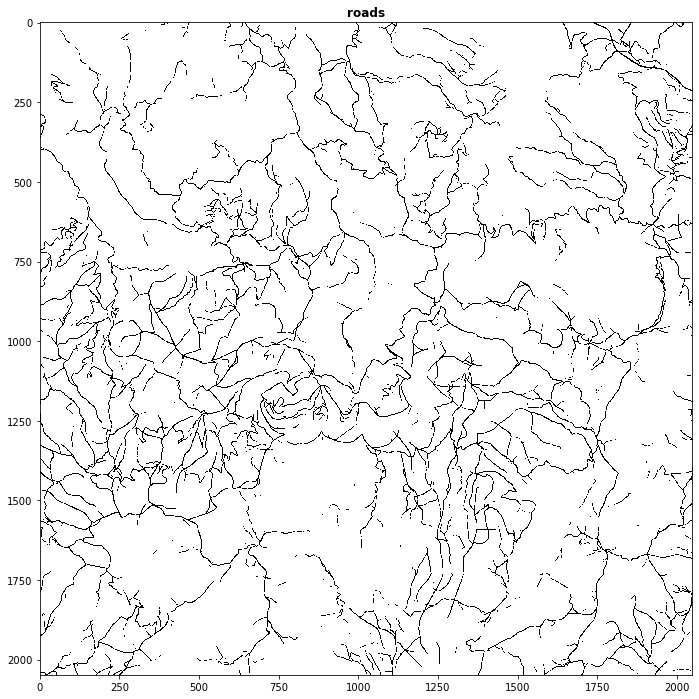

In [20]:
def _open(filename, factor=1):
    with rasterio.open(filename) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[0,:,:].astype(bool)

def get_figsize(factor):
    return tuple(2 * [int(25/factor)])

factor = 2
figsize = get_figsize(factor)

roads = open_bool(filename, factor=factor)
fig = plt.figure(figsize=figsize)
show(roads, title="roads", cmap="binary")

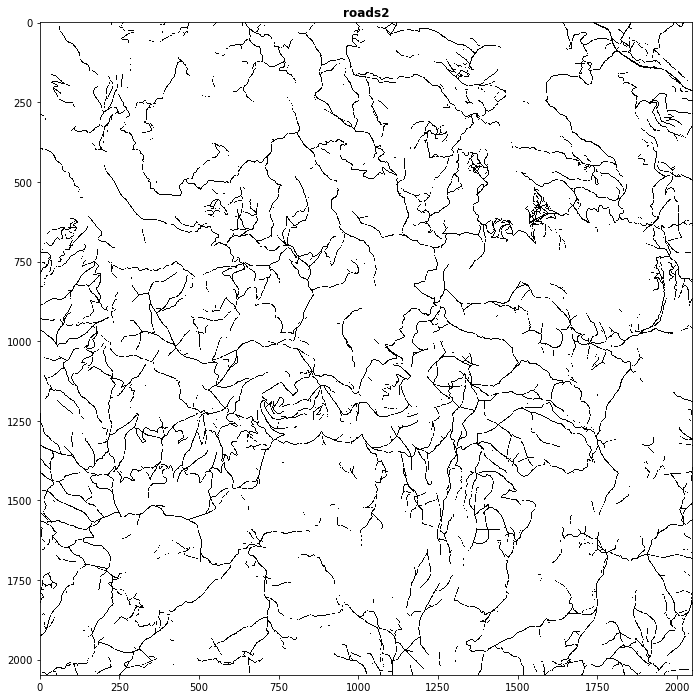

In [21]:
roads2 = open_bool(filename2, factor=factor)
fig = plt.figure(figsize=figsize)
show(roads2, title="roads2", cmap="binary")

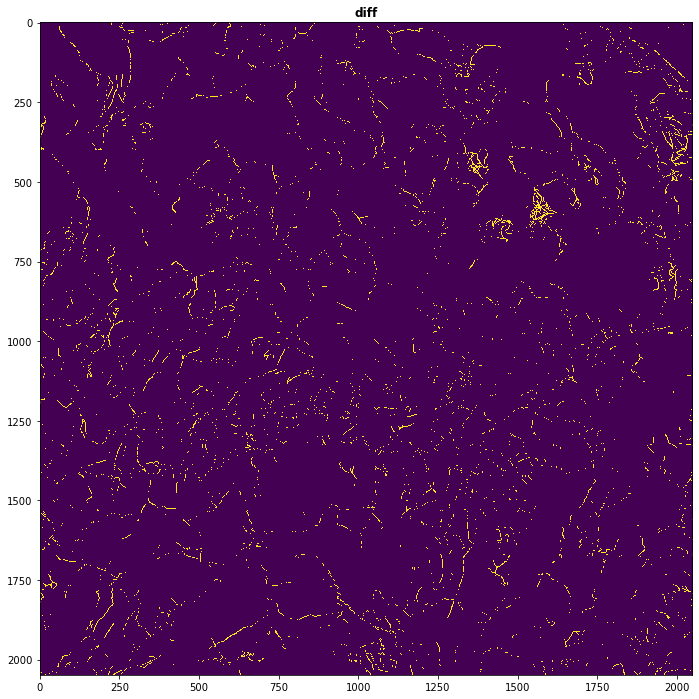

In [114]:
# Difference highlighting pixels where the two road images differ

fig = plt.figure(figsize=figsize)
diff = np.bitwise_xor(roads, roads2)
show(diff, title="diff")

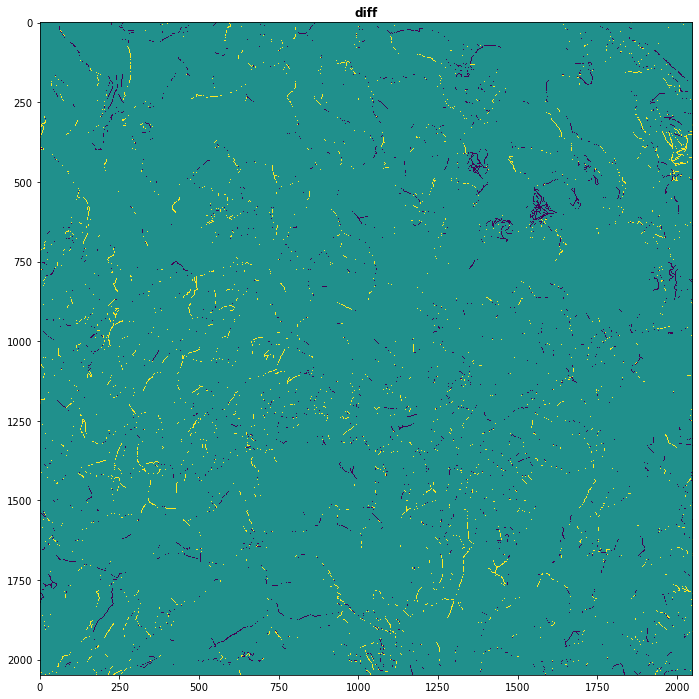

In [22]:
# Difference highlighting roads that have appeared (purple) or disappeared (yellow)

fig = plt.figure(figsize=figsize)
diff_subtraction = roads.astype(np.int8) - roads2.astype(np.int8)
show(diff_subtraction, title="diff")

## View source images

In a small region in the upper-right corner of the image, there appears to be a cluster of new roads. Let's check out the original satellite images.

In [26]:
source_dir = os.path.join(dest, 'source')
create_save_dir(source_dir)
source_resource_type = 'source-quad'

In [27]:
src_filename = download_feature(quad_features[0], SUBSCRIPTION_ID, source_resource_type, dest=source_dir)
src_filename2 = download_feature(quad_features[-1], SUBSCRIPTION_ID, source_resource_type, dest=source_dir)

6cabb1f3-218a-4956-9fa3-821c6379ac13: acquired 2017-08-01
file saved to: data/source/1175-1272_2017-08-01.tif
34e64cc6-52e7-4bf9-9069-54a321acab1e: acquired 2019-07-01
file saved to: data/source/1175-1272_2019-07-01.tif


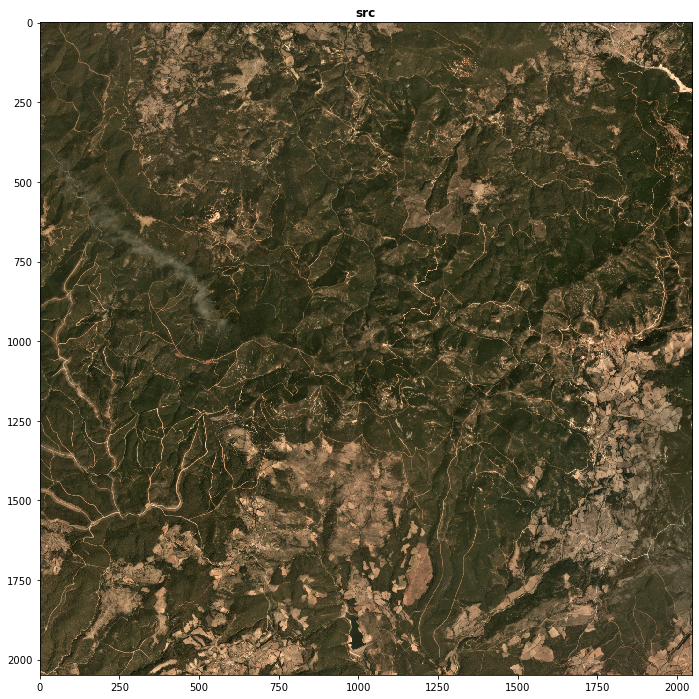

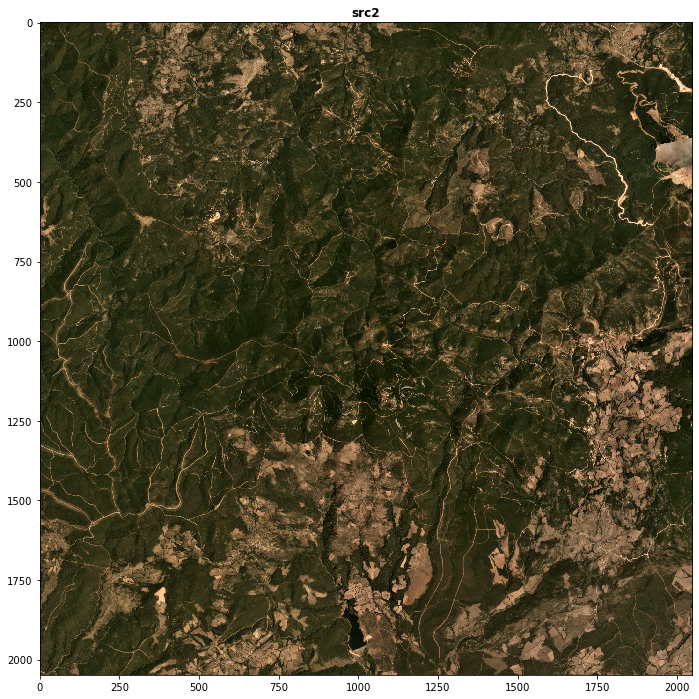

In [28]:
def open_rgb(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[:3,:,:]

src = open_rgb(src_filename, factor=factor)
fig = plt.figure(figsize=figsize)
show(src, title="src")
src2 = open_rgb(src_filename2, factor=factor)
fig = plt.figure(figsize=figsize)
show(src2, title="src2")

## Look at a subset of the imagery with change

Let's zoom in on the region with the new roads.

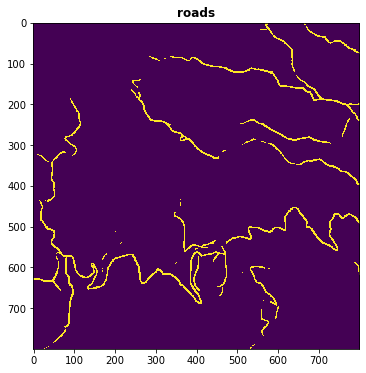

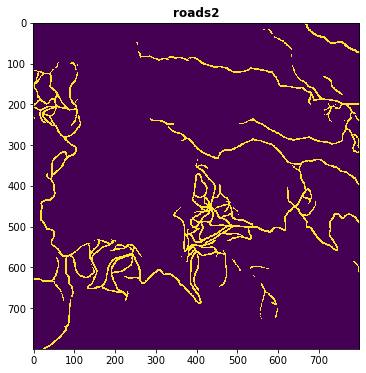

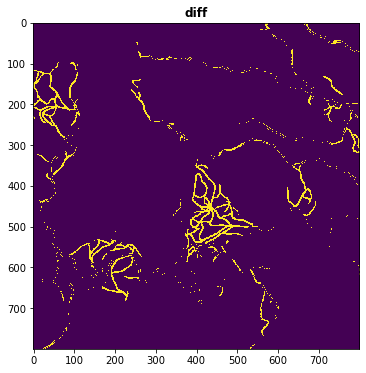

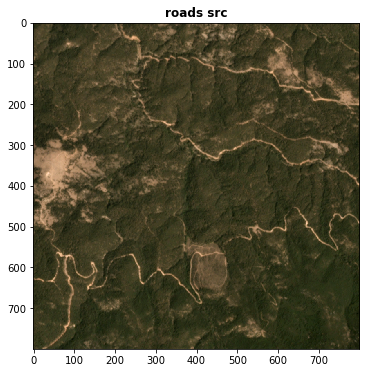

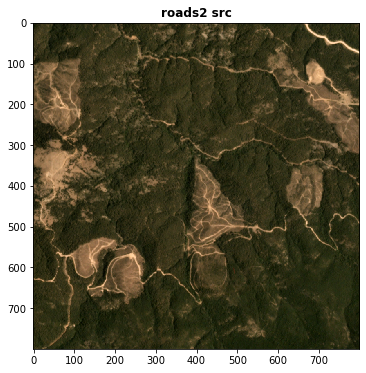

In [30]:
def get_subset(image, rmin, rmax, cmin, cmax, factor=1):
    if len(image.shape) == 3:
        img = image[:, int(rmin/factor):int(rmax/factor), int(cmin/factor):int(cmax/factor)]
    elif len(image.shape) == 2:
        img = image[int(rmin/factor):int(rmax/factor), int(cmin/factor):int(cmax/factor)]
    return img
        

sub_factor = 1
rmin, rmax, cmin, cmax = (700, 1500, 2700, 3500)

roads = open_bool(filename, factor=factor)
roads_subset = get_subset(open_bool(filename), rmin, rmax, cmin, cmax)
roads2_subset = get_subset(open_bool(filename2), rmin, rmax, cmin, cmax)

# diff_subset = roads_subset.astype(np.int8) - roads2_subset.astype(np.int8)
diff_subset = np.bitwise_xor(roads_subset, roads2_subset)

src_subset = get_subset(open_rgb(src_filename), rmin, rmax, cmin, cmax)
src2_subset = get_subset(open_rgb(src_filename2), rmin, rmax, cmin, cmax)

sub_figsize = (6, 6)
fig = plt.figure(figsize=sub_figsize)
show(roads_subset, title="roads")
fig = plt.figure(figsize=sub_figsize)
show(roads2_subset, title="roads2")
fig = plt.figure(figsize=sub_figsize)
show(diff_subset, title="diff")
fig = plt.figure(figsize=sub_figsize)
show(src_subset, title="roads src")
fig = plt.figure(figsize=sub_figsize)
show(src2_subset, title="roads2 src")